In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from random import seed, shuffle
import os

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
sns.set_theme(style="white")

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.cluster import KMeans, SpectralClustering

from scipy import stats
from scipy.spatial.distance import directed_hausdorff, euclidean, cosine, pdist

from src.downsample import downsamp_audio
import src.embedding_extractor as ee
import src.dimension_reducer as dr
import src.distance_metrics as dm

from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

#Directory where already-generated embeddings stored
embedding_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/embeddings'
emb_models = ['emb_ami', 'emb','emb_voxceleb'] #names of pretrained embedding extractor models. in any "all models" script we evaluate which one(s) might be best

##files starting with 020422 are from the recent recordings of actual moms sohye sent
## files starting with 020322 were all the test recordings from last year

#the directory has other csvs and i only want today's
#file = [file for file in os.listdir(embedding_dir) if file.startswith("022822")] 
file = '022822_postpartum_moms_20part_emb_ami.csv'

#create a dictionary where each item is the pd df of the embeddings extracted from that model
#all_embs = {emb_models[index]: ee.load_embs(os.path.join(embedding_dir,file[index])) for index in np.arange(len(file))}
emb = ee.load_embs(os.path.join(embedding_dir,file))

gemap_file = '020422_postpartum_moms_gemaps'
gemap = ee.load_embs(os.path.join(embedding_dir,file_out))


#choose 'emb_ami' as the embedding model to use because it seemed to result in best preserved high-dimension structure when dimension reduced
#emb = all_embs[emb_models[0]]
emb_down = ee.resample_data(emb,1)


Using cache found in /Users/rahulbrito/.cache/torch/hub/pyannote_pyannote-audio_master
Using cache found in /Users/rahulbrito/.cache/torch/hub/pyannote_pyannote-audio_master


In [20]:
###Run dimension reduction with different methods on the embeddings to establish a baseline before leaving any participants out

#Using tsne with perplexity=30 (default) since N/100<30, and learning rate of n/12. Random seed is 42 so the result is the same each time
emb_tsne = dr.run_tsne(emb_down, perplexity=80, init='pca', learning_rate=emb_down.shape[0]//12)

#run umap with default parameters
emb_umap = dr.run_umap(emb_down)

#run LDA for comparison
lda = LinearDiscriminantAnalysis()
X = emb_down.drop(columns='part_id')
labels = emb_down.part_id
emb_lda = pd.DataFrame(lda.fit_transform(X, labels))
emb_lda = emb_lda.iloc[:,:2]
emb_lda.columns = ['dim0', 'dim1']

#PCA for comparison
pca = PCA(n_components=512)
#exp_var = pca.fit(emb_down.drop(columns='part_id')).explained_variance_ratio_
emb_pca = pd.DataFrame(pca.fit_transform(emb_down.drop(columns='part_id')))
emb_pca = emb_pca.iloc[:,:2]
emb_pca.columns = ['dim0', 'dim1']

#sns.barplot(x=np.arange(20), y=exp_var[0:20]) #show PC expected variance


In [17]:
#measure 'knn', 'knc', 'cpd' to determine how well micro, meso, and marco structure of high-D preserved by dim reduction, per Kobak&Berens2019

#we are always comparing to emb_down as our high-dimension embedding. 
high_dim = emb_down.drop(columns='part_id').to_numpy()
classes= emb_down.part_id.to_numpy() #extract the categories/labels

#compare tsne to embeddings
low_dim = emb_tsne.drop(columns='part_id').to_numpy()
dist_tsne = dm.embedding_quality(high_dim, low_dim, classes,subsetsize=emb_down.shape[0])

#compare umap to embeddings
low_dim = emb_umap.drop(columns='part_id').to_numpy()
dist_umap = dm.embedding_quality(high_dim, low_dim, classes,subsetsize=emb_down.shape[0])

#compare lda to embeddings
low_dim = emb_lda.to_numpy()
dist_lda = dm.embedding_quality(high_dim, low_dim, classes, subsetsize=emb_down.shape[0])

#compare pca to embeddings
low_dim = emb_pca.to_numpy()
dist_pca = dm.embedding_quality(high_dim, low_dim, classes, subsetsize=emb_down.shape[0])

#create a dataframe of all distance metrics for each dimension method
dist = pd.DataFrame(np.vstack((dist_tsne, dist_umap,dist_lda,dist_pca)), columns = ['micro', 'meso', 'macro'], index = ['tsne', 'umap', 'lda','pca'])
dist = dist.round(decimals=3)
dist.loc['tsne']

micro    0.467
meso     0.782
macro    0.728
Name: tsne, dtype: float64

[Text(0.5, 1.0, '     micro   meso  macro\npca  0.092  0.841  0.804')]

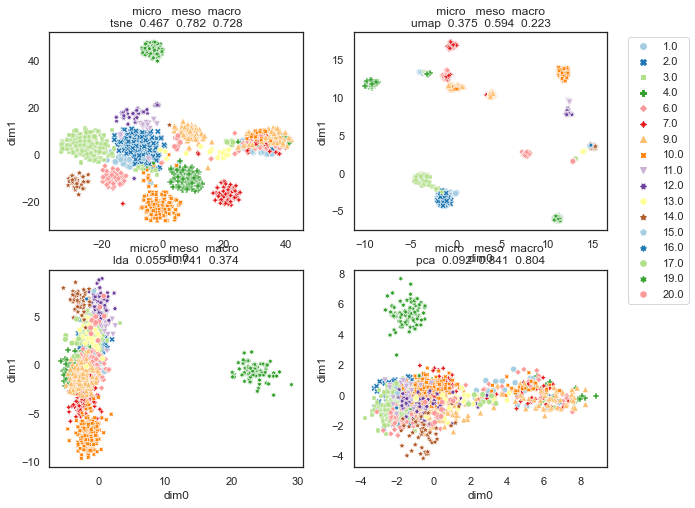

In [5]:
##plot 2 dimensions from each dimension reduction
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(10,8))

clust_plt_tsne = sns.scatterplot(x=emb_tsne.dim0, y=emb_tsne.dim1, ax=ax1, palette="Paired", hue=emb_tsne.part_id, style=emb_tsne.part_id, legend=False)
#ax1.legend(loc="lower center",bbox_to_anchor=(1.3,1), ncol=2)
clust_plt_tsne.set(title = str(dist[dist.index=='tsne']))

clust_plt_umap = sns.scatterplot(x=emb_umap.dim0, y=emb_umap.dim1, ax=ax2, palette="Paired", hue=emb_umap.part_id, style=emb_tsne.part_id)
ax2.legend(loc="lower center",bbox_to_anchor=(1.2, -0.4), ncol=1)
clust_plt_umap.set(title = str(dist[dist.index=='umap']))

clust_plt_lda = sns.scatterplot(x=emb_lda.dim0, y= emb_lda.dim1, ax=ax3, palette="Paired", hue = labels, style=emb_tsne.part_id, legend=False)
#ax3.legend(loc="lower center",bbox_to_anchor=(1.3, 0.4), ncol=2)
clust_plt_lda.set(title = str(dist[dist.index=='lda']))

clust_plt_pca = sns.scatterplot(x=emb_pca.dim0, y= emb_pca.dim1, ax=ax4, palette="Paired", hue = labels, style=emb_tsne.part_id, legend=False)
#ax4.legend(loc="lower center",bbox_to_anchor=(1.3, 0.4), ncol=2)
clust_plt_pca.set(title = str(dist[dist.index=='pca']))


In [2]:
import opensmile
import os
import glob

In [3]:
down_sampled_dir='/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/16khz_020422_postpartum_moms/'
audio_files = glob.glob(down_sampled_dir+'*', recursive=True)

smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
    verbose=True,
)
gemap = smile.process_files(audio_files)

In [8]:
embedding_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/embeddings'

gemap.to_csv(os.path.join(embedding_dir,file_out))

In [ ]:
test

,start,end,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
file,,,,,,,,,,,,,,,,,,,,,
/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/16khz_020422_postpartum_moms/014.wav,0 days,0 days 00:07:45.860500,34.656258,0.226665,29.325533,32.339630,37.971905,8.646372,417.31317,756.03970,...,0.034896,0.025749,0.027282,1.884727,1.676721,0.197657,0.175015,0.396689,1.097285,-29.941727
/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/16khz_020422_postpartum_moms/001.wav,0 days,0 days 00:07:55.900437500,40.614002,0.193990,33.898705,38.412937,48.591347,14.692642,259.02628,344.97830,...,-0.009542,0.015704,0.041610,2.023577,2.042703,0.268282,0.310515,0.240248,0.514109,-27.318361
/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/16khz_020422_postpartum_moms/015.wav,0 days,0 days 00:07:36.144437500,40.012825,0.161124,34.837110,39.588940,45.550262,10.713154,231.97970,359.49014,...,0.061847,0.007072,0.080939,2.109048,1.968953,0.266091,0.315487,0.251745,1.239365,-26.354046
/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/16khz_020422_postpartum_moms/003.wav,0 days,0 days 00:08:18.660437500,38.130420,0.165808,32.843327,36.665283,42.954690,10.111362,212.71884,369.81903,...,-0.012003,0.012537,0.087544,1.871052,2.005616,0.209840,0.224457,0.282699,0.540035,-21.986076
/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/16khz_020422_postpartum_moms/017.wav,0 days,0 days 00:07:38.837937500,34.798317,0.137045,32.089806,34.590267,37.231243,5.141438,156.26746,403.00116,...,0.049451,0.016761,0.035364,1.985528,1.621728,0.284073,0.266139,0.330600,0.742869,-26.701868
/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/16khz_020422_postpartum_moms/016.wav,0 days,0 days 00:08:00.420437500,36.757298,0.207710,30.193680,35.667973,42.064240,11.870560,241.57968,521.67070,...,0.043272,0.018943,0.033887,2.033679,1.692516,0.237146,0.236825,0.363136,1.277003,-25.765015
/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/16khz_020422_postpartum_moms/002.wav,0 days,0 days 00:09:03.270437500,41.346184,0.193928,33.896748,40.291460,48.581110,14.684361,242.58864,363.40833,...,-0.007387,0.010263,0.047721,1.986158,1.840942,0.177130,0.202996,0.307970,0.498998,-29.922302
/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/16khz_020422_postpartum_moms/006.wav,0 days,0 days 00:07:42.470437500,39.151253,0.200883,33.308697,36.586136,45.129265,11.820568,292.00543,477.85782,...,-0.012655,0.019526,0.041911,2.212083,2.067429,0.194195,0.175429,0.291202,0.530252,-29.348478
/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/16khz_020422_postpartum_moms/012.wav,0 days,0 days 00:10:02.250437499,37.890427,0.199913,32.722797,36.460660,42.930946,10.208149,339.92280,572.84937,...,0.048792,0.020148,0.049410,2.060640,1.660605,0.183360,0.204085,0.377940,1.063458,-25.793747


In [77]:
emb_a = ee.embedding_averager(emb_down)

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,-0.002461,0.003887,-0.003973,0.002701,0.000109,0.005179,-0.011450,0.002896,-0.008226,-0.006068,...,0.000560,-0.004171,0.009054,-0.008971,-0.000946,0.001654,-0.013777,-0.000457,0.002211,0.003010
1,-0.002172,0.009753,-0.004171,0.003211,0.002180,0.003533,-0.005378,0.002504,-0.001943,-0.012896,...,-0.005353,-0.007531,0.010541,-0.012106,-0.007888,0.000332,-0.007248,0.005138,0.015072,0.002261
2,-0.001980,0.006840,-0.008592,-0.002759,-0.002511,0.002191,-0.006835,-0.003022,-0.002301,-0.012461,...,0.000580,-0.006715,0.016988,-0.013453,-0.004794,0.009939,-0.008936,0.006760,0.008582,0.002249
3,-0.001314,0.011325,-0.007732,0.002250,0.000807,0.002772,-0.003417,0.003374,-0.007426,-0.011401,...,0.001315,-0.010117,0.009334,-0.014434,-0.002495,0.006452,-0.005352,0.007271,0.017996,0.007333
4,-0.003616,0.009074,-0.003322,0.000404,0.002435,0.005093,-0.005415,-0.001778,-0.003969,-0.007792,...,-0.002736,-0.000702,0.010935,-0.010646,-0.005570,-0.001682,-0.008600,0.009422,0.017614,0.004669
5,-0.001066,0.003366,-0.006220,-0.000659,-0.000069,0.008732,-0.008717,0.007088,-0.006345,-0.006683,...,0.000218,0.002071,0.005963,-0.004515,-0.007400,-0.011323,-0.008431,-0.000097,0.011497,-0.000197
6,-0.010147,0.005720,-0.017153,-0.003108,-0.006163,0.011265,-0.007695,0.002263,-0.012392,-0.006894,...,0.009938,-0.003851,0.023083,-0.009936,0.004919,0.007021,-0.005871,0.009255,0.004859,0.010289
7,0.003812,0.008804,-0.010106,-0.000324,0.004288,0.001069,-0.007518,0.002178,0.000180,-0.009591,...,-0.000090,-0.006368,0.008485,-0.005139,-0.003884,0.006279,-0.007922,0.007296,0.014645,0.000901
8,-0.004785,0.002158,-0.012484,0.002888,0.002549,0.008867,-0.010588,0.006248,-0.011560,-0.003911,...,0.000114,-0.004617,0.009832,-0.004925,-0.000657,-0.008415,-0.010263,0.000263,0.005198,0.007687
9,0.000117,0.004459,-0.009458,-0.001625,0.000197,0.004933,-0.006140,0.002217,-0.006996,-0.005327,...,0.000054,-0.004962,0.009704,-0.009250,-0.006256,-0.002136,-0.009713,0.004919,0.005169,0.004771


In [78]:
from sklearn.cross_decomposition import CCA

X = emb_a.drop(columns='part_id')
Y = gemap

cca = CCA()
cca.fit(X, Y)
X_c, Y_c = cca.transform(X, Y)

<AxesSubplot:>

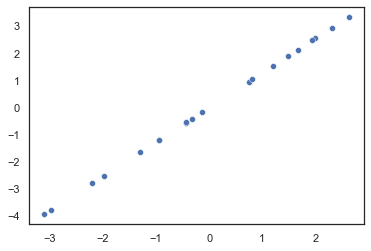

In [79]:
sns.scatterplot(x=X_c[:,0], y=Y_c[:,0])

In [80]:
np.corrcoef(X_c[:,0],Y_c[:,0])

array([[1., 1.],
       [1., 1.]])